# Sentiment Analysis of Killing Eve TV Series

The purpose of this project was to predict polarity of reviews of web scraped data from Rotten Tomatoes (critics and audience reviews) and IMBD websites for popular TV Series - Killing Eve using lexicon-based libraries like nltk-VADER, TextBlob - and machine learning classifiers such as Naive Bayes or Stochastic Gradient Descent(SGD) while dealing with imbalanced data.

In [1]:
# importing libraries

import numpy as np
import pandas as pd 
import re
import string
import inflect
from langdetect import detect_langs
import emoji

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "png" #for switching interactive visualizations to static 

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.probability import FreqDist


from textblob import TextBlob
from nltk.sentiment import vader

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline


from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report,confusion_matrix

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from joblib import dump

import warnings
warnings.filterwarnings('ignore')

---------

### 1. Gathering previously web scraped data  and concatinating it to one dataframe

In [2]:
# loading data
df1 = pd.read_csv('rotten_tomatoes_reviews.csv') # rotten tomatoes critics reviews
df2 = pd.read_csv('rotten_tomatoes_audience_reviews.csv') # rotten tomatoes audience reviews
df3 = pd.read_csv('imbd_reviews.csv') # imbd reviews 

In [3]:
df1.head()

,reviews,sentiment
0,It manages...,positive
1,Sandra Oh ...,positive
2,What disti...,positive
3,[A] perfec...,positive
4,The Britis...,positive


In [4]:
df2.head()

,reviews,sentiment
0,"Fresh, weird, strange and absolutely incredibl...",5.0
1,This is probably the best tv show I have ever ...,5.0
2,The season that started it all!,5.0
3,Love this series so much! I am so excited to c...,5.0
4,Fine and subtle series. Excellent filmed and p...,5.0


In [5]:
# replacing scores with positive or negative sentiment

df2['sentiment'].replace(to_replace=[3.5,4,4.5,5,5.5],value='positive',inplace=True)
df2['sentiment'].replace(to_replace=[1,1.5,2,2.5],value='negative',inplace=True)

In [6]:
df2 = df2[df2.sentiment != 3] # removing reviews with score equal to 3 because they seem to be more neutral 

In [7]:
df3.head()

,reviews,sentiment
0,"Sandra Oh is wonderful, as is all the cast in ...",10
1,This show had me hooked after two minutes. Wha...,10
2,I love the show. INTRIGUING! Someone wrote tha...,10
3,Season 1 might be one of the best seasons of a...,10
4,"There are many good thrillers out there, where...",10


In [8]:
# replacing scores with positive or negative sentiment

df3['sentiment'].replace(to_replace=[1,2,3,4],value='negative',inplace=True)
df3['sentiment'].replace(to_replace=[7,8,9,10],value='positive',inplace=True)

# getting rid of reviews with score equal to 5 and 6 because they seem to be more neutral 
df3 = df3[df3.sentiment != 5] 
df3 = df3[df3.sentiment != 6] 

In [9]:
# concatinating dataframes
df = pd.concat([df1,df2,df3],ignore_index=True, sort=False)

In [10]:
print(f'Number of observations: {df.shape[0]}')
print(f'Number of variables: {df.shape[1]}')

Number of observations: 1204
Number of variables: 2


----------

### 2. Data cleaning 

In [11]:
def clean_text(text):
    '''Make text lowercase, remove punctuation, remove words containing numbers and remove leading or trailing spaces.'''
    text = text.lower() #lowercase
    text = ''.join([i for i in text if i not in string.punctuation]) #removing punctuation
    #text = re.sub('\w*\d\w*', '', text) #removing numbers
    text = text.strip() # removing leading or trailing spaces
    text = re.sub('\n',  '', text)
    text = emoji.demojize(text)
    return text

In [12]:
df['reviews']=df['reviews'].apply(lambda x: clean_text(x))

In [13]:
df.isna().sum()

reviews      0
sentiment    0
dtype: int64

In [14]:
df['length'] = df['reviews'].str.len() # compute the length of each element in the Series

In [15]:
max(df['length'])

6033

In [16]:
min(df['length'])

1

In [17]:
len(df[df['length']==1])

37

In [18]:
df[df['length']==1].head()

,reviews,sentiment,length
588,0,positive,1
601,0,negative,1
643,0,positive,1
654,0,negative,1
672,0,positive,1


Aparently dataset contains 37 reviews without any review - just with number 0, that's why they need to be removed.

In [19]:
df = df[df['length'] != 1] #removing those reviews

In [20]:
inflect= inflect.engine()

In [21]:
def num_to_word(text): 
    ''' Convering numbers to words'''
    words = ''
    for word in text:
        if word.isdigit():
            words += inflect.number_to_words(word)
        else:
            words += word
    return words

In [22]:
df['reviews']=df['reviews'].apply(lambda x: num_to_word(x))

In [23]:
# detecting a language with langdetect 
languages=[]
for index, review in enumerate(df['reviews']):
    languages.append(detect_langs(review))    

In [24]:
languages = [str(language).split(':')[0][1:] for language in languages]

In [25]:
df['languages']=languages #creating new column with review language

In [26]:
df['languages'].value_counts() 

en    1156
pt       3
so       1
es       1
hu       1
no       1
fr       1
da       1
ro       1
af       1
Name: languages, dtype: int64

The majority of reviews is written in english, but there still are single reviews written in different languages.

In [27]:
df = df[df['languages']=='en'] # getting rid of reviews that are not in written in english

-------------

### 3. Exploratory data analysis (EDA)

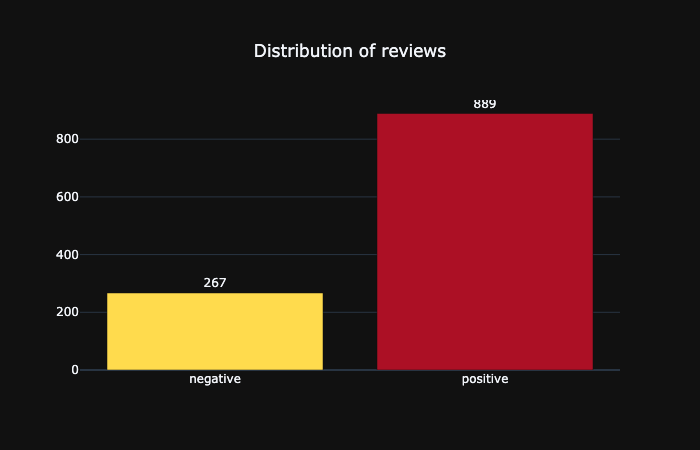

In [28]:
sentiment = df.groupby(['sentiment']).size().rename('count').reset_index().sort_values('sentiment')
fig = go.Figure([go.Bar(x=sentiment['sentiment'],y=sentiment['count'],text=sentiment['count'],marker_color=['#ffdb4d','#ac1025'])])
fig.update_layout(template="plotly_dark")
fig.update_traces(textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.update_layout(title={'text': "Distribution of reviews",'y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'})
fig.show()

In [29]:
sentiments = df['sentiment'].value_counts()/len(df)
print(f'Postive reviews  : {sentiments.positive:.1%}')
print(f'Negative reviews : {sentiments.negative:.1%}')

Postive reviews  : 76.9%
Negative reviews : 23.1%


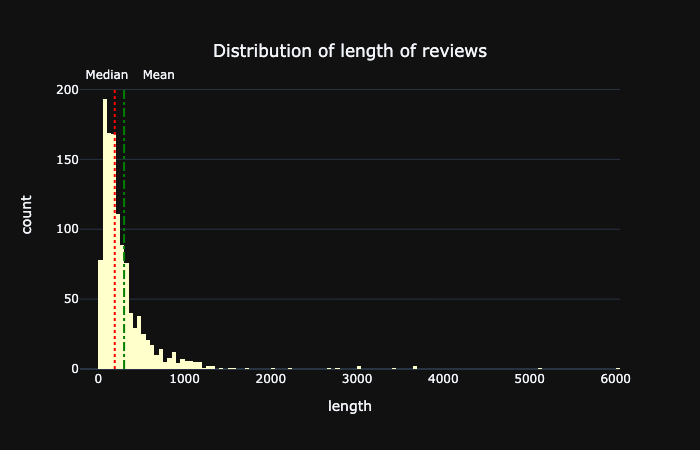

In [30]:
fig = px.histogram(df, x="length",color_discrete_sequence=px.colors.sequential.YlOrRd)
fig.add_shape(
        # Line Vertical
        dict(
            type="line",
            x0=df['length'].mean(),
            x1=df['length'].mean(),
            y0=0,
            y1=200,
            line=dict(
                color="green",
                width=2,
                dash="dashdot"
            )
))
fig.add_shape(
        # Line Vertical
        dict(
            type="line",
            x0=df['length'].median(),
            x1=df['length'].median(),
            y0=0,
            y1=200,
            line=dict(
                color="red",
                width=2, dash="dot"
            )
))
fig.add_trace(go.Scatter(
    x=[100, 700],
    y=[210, 210],
    text=['Median','Mean'],
    mode="text"))
fig.update_layout(template="plotly_dark")
fig.update_layout(title={'text': "Distribution of length of reviews",'y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'})
fig.update_layout(showlegend=False)
fig.show()

In [31]:
df.head()

,reviews,sentiment,length,languages
0,it manages this wonderful blend of wit humor a...,positive,96,en
1,sandra oh finally has a role worthy of her act...,positive,55,en
2,what distinguishes killing eve isnt just that ...,positive,137,en
3,a perfect puzzle full review in spanish,positive,39,en
4,the britishmade drama is intriguingly strange ...,positive,105,en


In [32]:
print(f"Mean length of reviews: {df['length'].mean()}")
print(f"Median length of reviews: {df['length'].median()}")

Mean length of reviews: 298.46020761245677
Median length of reviews: 189.5


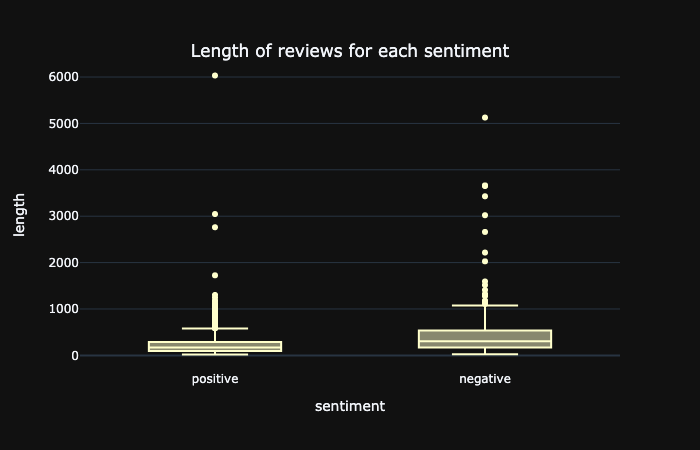

In [33]:
fig = px.box(df, x="sentiment", y="length",color_discrete_sequence=px.colors.sequential.YlOrRd)
fig.update_layout(template="plotly_dark")
fig.update_layout(title={'text': "Length of reviews for each sentiment",'y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'})
fig.update_layout(showlegend=False)
fig.show()

Negative reviews tend to be a little longer than positive reviews. 

In [34]:
stop_words = set(stopwords.words('english'))

In [35]:
text= ' '.join(df['reviews'])

In [36]:
wt = WhitespaceTokenizer()
text = wt.tokenize(text)

In [37]:
f'Dataset contains {len(text)} from which {len(set(text))} are unique'

'Dataset contains 62028 from which 6857 are unique'

In [38]:
def most_frequent(words, colors):
    ''' Create a bar plot of most frequent words in corpus with stopwords removal'''
    filtered_words = []
    for w in words:
        if w not in stop_words: 
            filtered_words.append(w)
    freq_dist = FreqDist(filtered_words)
    most_common = pd.DataFrame(freq_dist.most_common(20),columns=['words','count'])
    fig = px.bar(most_common, x='words', y='count',color_discrete_sequence=colors,color='words') # top 20 words in dataframe
    fig.update_layout(template="plotly_dark")
    fig.update_layout(title={'text': "20 Most Frequent Words",'y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'})
    fig.update_layout(showlegend=False)
    return fig.show()

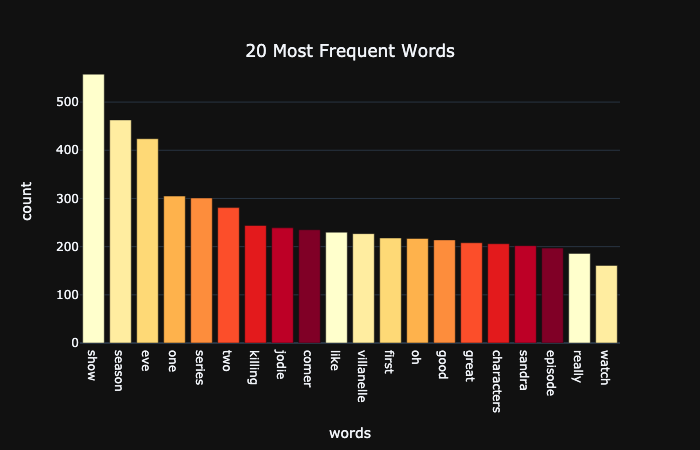

In [39]:
most_frequent(text,px.colors.sequential.YlOrRd)

In [40]:
# updating stop words list
stop_words.update(['killing','eve','show','season','series','jodie','sandra','oh','comer','villanelle','episode','episodes','seasons','tv','serie','one','two'])

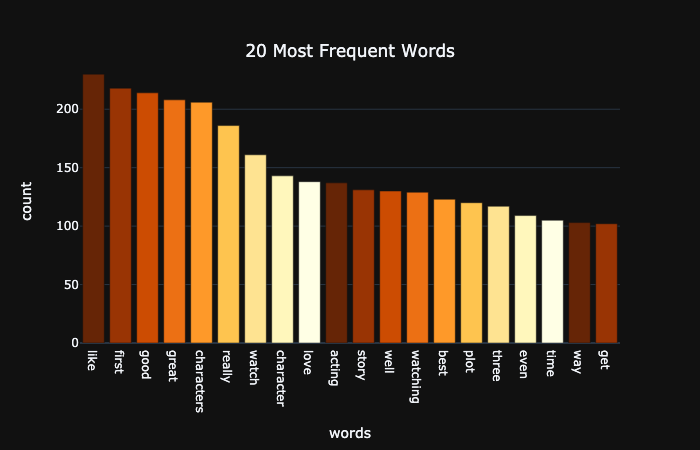

In [41]:
most_frequent(text,px.colors.sequential.YlOrBr_r)

In [42]:
def word_cloud(reviews,color):
    ''' Visualizing a word cloud '''
    cloud = WordCloud(width = 700, height = 300, background_color = 'black',stopwords=stop_words, min_font_size = 10,colormap=color).generate(reviews)
    plt.figure(figsize=[17, 15])
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [43]:
positive = df[df['sentiment']=='positive']
positive_reviews = ' '.join(positive['reviews'])

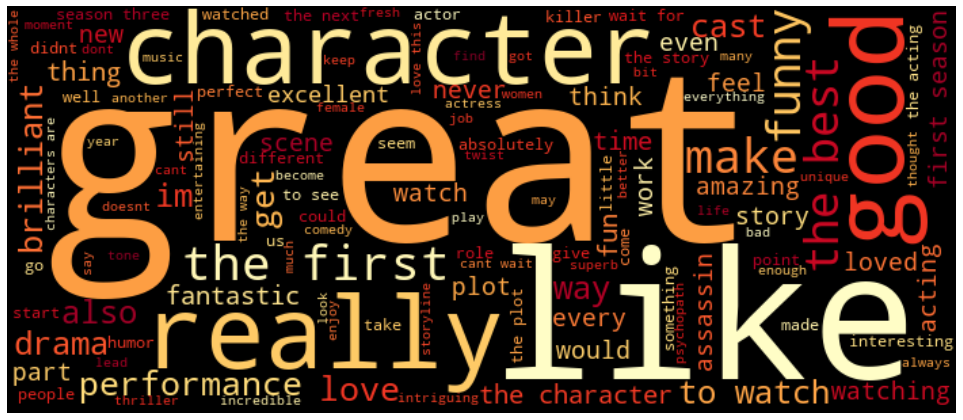

In [44]:
word_cloud(positive_reviews,'YlOrRd')  # word cloud for positive reviews

In [45]:
negative = df[df['sentiment']=='negative']
negative_reviews = ' '.join(negative['reviews'])

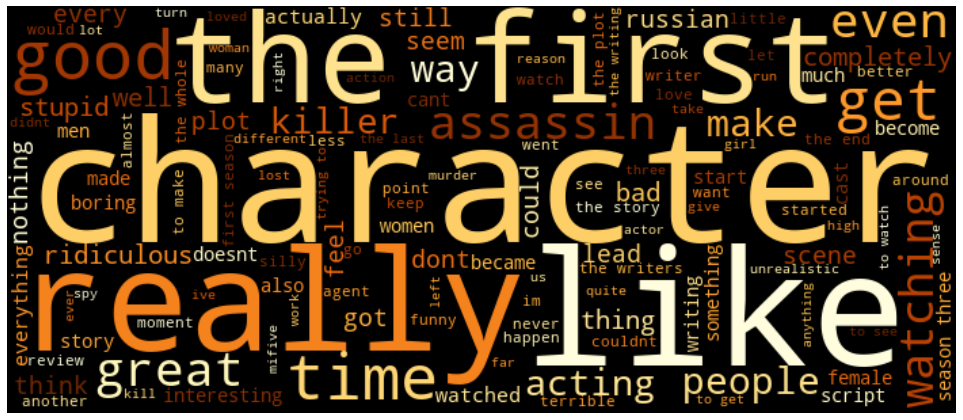

In [46]:
word_cloud(negative_reviews,'YlOrBr_r') # word cloud for negative reviews

-------------

### 4. Lexicon based approaches - Vader, TextBlob

In [47]:
labelencoder = LabelEncoder() 

In [48]:
df['sentiment'] = labelencoder.fit_transform(df['sentiment'])

In [49]:
sia = vader.SentimentIntensityAnalyzer()

In [50]:
df['scores'] = df['reviews'].apply(lambda review: sia.polarity_scores(review))

df['compound']  = df['scores'].apply(lambda score_dict: score_dict['compound'])

df['comp_score'] = df['compound'].apply(lambda score: 1 if  score >=0 else 0)

df.head()

,reviews,sentiment,length,languages,scores,compound,comp_score
0,it manages this wonderful blend of wit humor a...,1,96,en,"{'neg': 0.141, 'neu': 0.42, 'pos': 0.438, 'com...",0.7766,1
1,sandra oh finally has a role worthy of her act...,1,55,en,"{'neg': 0.0, 'neu': 0.756, 'pos': 0.244, 'comp...",0.4404,1
2,what distinguishes killing eve isnt just that ...,1,137,en,"{'neg': 0.19, 'neu': 0.693, 'pos': 0.117, 'com...",-0.4019,0
3,a perfect puzzle full review in spanish,1,39,en,"{'neg': 0.0, 'neu': 0.575, 'pos': 0.425, 'comp...",0.5719,1
4,the britishmade drama is intriguingly strange ...,1,105,en,"{'neg': 0.098, 'neu': 0.543, 'pos': 0.359, 'co...",0.7003,1


In [51]:
print(classification_report(df['sentiment'],df['comp_score']))

              precision    recall  f1-score   support

           0       0.50      0.63      0.56       267
           1       0.88      0.81      0.84       889

    accuracy                           0.77      1156
   macro avg       0.69      0.72      0.70      1156
weighted avg       0.79      0.77      0.78      1156



In [52]:
f1_score(df['sentiment'],df['comp_score'],average='weighted')

0.7755780666057902

In [53]:
polarity = lambda x: TextBlob(x).sentiment.polarity
df['polarity'] = df['reviews'].apply(polarity)
df['score'] = df['polarity'].apply(lambda score: 1  if score >=0 else 0)

In [54]:
print(classification_report(df['sentiment'],df['score']))

              precision    recall  f1-score   support

           0       0.58      0.48      0.52       267
           1       0.85      0.90      0.87       889

    accuracy                           0.80      1156
   macro avg       0.72      0.69      0.70      1156
weighted avg       0.79      0.80      0.79      1156



In [55]:
f1_score(df['sentiment'],df['score'],average='weighted')

0.7927583295713467

----------------

In [56]:
# removing stopwords
stop_words.difference_update({"aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't","mightn't","mustn't","needn't",'not',"shouldn't",'t', "wasn't","weren't","won't","wouldn't"})

### 5.  CountVectorizer

In [57]:
X = df['reviews']
y = df['sentiment']

In [58]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=0,shuffle=True)

In [59]:
# creating pipeline for CountVectorizer & MultinomialNB
nb_cv_pipeline = Pipeline([('vect', CountVectorizer()),
                           ('clf', MultinomialNB())])

In [60]:
parameters_nb = {'vect__ngram_range': [(1, 1), (1, 2)],
                 'vect__min_df':[5,10,30],
                 'vect__stop_words': [stop_words, None,{'english'}],
                 'clf__alpha':[1, 1e-1, 1e-2,]}

In [61]:
nb_cv = GridSearchCV(nb_cv_pipeline, parameters_nb, cv=5, scoring='f1_weighted')
nb_cv = nb_cv.fit(X_train, y_train)

In [62]:
nb_cv.best_params_

{'clf__alpha': 0.1,
 'vect__min_df': 5,
 'vect__ngram_range': (1, 2),
 'vect__stop_words': {'english'}}

In [63]:
y_preds_nb_cv = nb_cv.predict(X_test)

In [64]:
def print_report(name,y_test,y_preds):
    ''' Print classification report'''
    print(f"\nClassification Report for {name}\n")
    print(classification_report(y_test, y_preds_nb_cv))

In [65]:
print_report('MultinomialNB with CountVectorizer',y_test,y_preds_nb_cv)


Classification Report for MultinomialNB with CountVectorizer

              precision    recall  f1-score   support

           0       0.69      0.76      0.73        54
           1       0.92      0.90      0.91       178

    accuracy                           0.87       232
   macro avg       0.81      0.83      0.82       232
weighted avg       0.87      0.87      0.87       232



In [66]:
f1_score(y_test,y_preds_nb_cv,average='weighted')

0.8683838059791676

In [67]:
# creating pipeline for CountVectorizer & SGD Classifier
sgd_cv_pipeline= Pipeline([
('vect', CountVectorizer()),
('clf', SGDClassifier(class_weight='balanced'))])

In [68]:
parameters_sgd = {'vect__ngram_range': [(1, 1), (1, 2)],
                  'vect__min_df':[0.1,5,10],
                  'vect__stop_words': [stop_words, None,{'english'}],
                  'clf__loss':['hinge','log','modified_huber'],
                  'clf__penalty': ('l2', 'elasticnet')}

In [69]:
sgd_cv = GridSearchCV(sgd_cv_pipeline, parameters_sgd, cv=5, scoring='f1_weighted')
sgd_cv = sgd_cv.fit(X_train, y_train)

In [70]:
sgd_cv.best_params_

{'clf__loss': 'modified_huber',
 'clf__penalty': 'l2',
 'vect__min_df': 5,
 'vect__ngram_range': (1, 1),
 'vect__stop_words': {'a',
  'about',
  'above',
  'after',
  'again',
  'against',
  'ain',
  'all',
  'am',
  'an',
  'and',
  'any',
  'are',
  'aren',
  'as',
  'at',
  'be',
  'because',
  'been',
  'before',
  'being',
  'below',
  'between',
  'both',
  'but',
  'by',
  'can',
  'comer',
  'couldn',
  'd',
  'did',
  'didn',
  'do',
  'does',
  'doesn',
  'doing',
  'don',
  'down',
  'during',
  'each',
  'episode',
  'episodes',
  'eve',
  'few',
  'for',
  'from',
  'further',
  'had',
  'hadn',
  'has',
  'hasn',
  'have',
  'haven',
  'having',
  'he',
  'her',
  'here',
  'hers',
  'herself',
  'him',
  'himself',
  'his',
  'how',
  'i',
  'if',
  'in',
  'into',
  'is',
  'isn',
  'it',
  "it's",
  'its',
  'itself',
  'jodie',
  'just',
  'killing',
  'll',
  'm',
  'ma',
  'me',
  'mightn',
  'more',
  'most',
  'mustn',
  'my',
  'myself',
  'needn',
  'no',
  'nor

In [71]:
y_preds_sgd_cv = sgd_cv.predict(X_test)

In [72]:
print_report('SGDClassifier with CountVectorizer',y_test,y_preds_sgd_cv)


Classification Report for SGDClassifier with CountVectorizer

              precision    recall  f1-score   support

           0       0.69      0.76      0.73        54
           1       0.92      0.90      0.91       178

    accuracy                           0.87       232
   macro avg       0.81      0.83      0.82       232
weighted avg       0.87      0.87      0.87       232



In [73]:
f1_score(y_test,y_preds_sgd_cv,average='weighted')

0.8085154807403271

In [74]:
def confusion_matrix_visualize(confusion_matrix_1,confusion_matrix_2):
    ''' Visualizing confusion matrixes '''
    fig, axarr = plt.subplots(1, 2, figsize=(13, 4))

    sns.heatmap(confusion_matrix_1,annot=True,annot_kws={"size": 15}, fmt='.3g',ax=axarr[0],cmap='OrRd',cbar=False)

    axarr[0].set_title("MultinomialNB", fontsize=14)

    sns.heatmap(confusion_matrix_2,annot=True,annot_kws={"size": 15}, fmt='.3g',ax=axarr[1],cmap='YlOrRd',cbar=False)

    axarr[1].set_title("SGDClassifier", fontsize=14)
    
    plt.subplots_adjust()

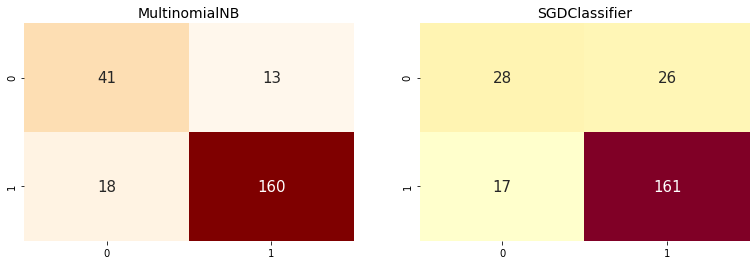

In [75]:
confusion_matrix_visualize(confusion_matrix(y_test,y_preds_nb_cv),confusion_matrix(y_test,y_preds_sgd_cv))

MultinomialNB predicted correctly more reviews than SGDClassifier.

### 6. Tf-idf Vectorizer

In [76]:
nb_tfidf_pipeline = Pipeline([
('vect', TfidfVectorizer()),
('clf', MultinomialNB())])

In [77]:
nb_tfidf = GridSearchCV(nb_tfidf_pipeline, parameters_nb, cv=5, scoring='f1_weighted')
nb_tfidf = nb_tfidf.fit(X_train, y_train)

In [78]:
nb_tfidf.best_params_

{'clf__alpha': 0.1,
 'vect__min_df': 5,
 'vect__ngram_range': (1, 2),
 'vect__stop_words': {'a',
  'about',
  'above',
  'after',
  'again',
  'against',
  'ain',
  'all',
  'am',
  'an',
  'and',
  'any',
  'are',
  'aren',
  'as',
  'at',
  'be',
  'because',
  'been',
  'before',
  'being',
  'below',
  'between',
  'both',
  'but',
  'by',
  'can',
  'comer',
  'couldn',
  'd',
  'did',
  'didn',
  'do',
  'does',
  'doesn',
  'doing',
  'don',
  'down',
  'during',
  'each',
  'episode',
  'episodes',
  'eve',
  'few',
  'for',
  'from',
  'further',
  'had',
  'hadn',
  'has',
  'hasn',
  'have',
  'haven',
  'having',
  'he',
  'her',
  'here',
  'hers',
  'herself',
  'him',
  'himself',
  'his',
  'how',
  'i',
  'if',
  'in',
  'into',
  'is',
  'isn',
  'it',
  "it's",
  'its',
  'itself',
  'jodie',
  'just',
  'killing',
  'll',
  'm',
  'ma',
  'me',
  'mightn',
  'more',
  'most',
  'mustn',
  'my',
  'myself',
  'needn',
  'no',
  'nor',
  'now',
  'o',
  'of',
  'off',

In [79]:
y_preds_nb_tfidf = nb_tfidf.predict(X_test)

In [80]:
print_report('MultinomialNB with TfidfVectorizer',y_test,y_preds_nb_tfidf)


Classification Report for MultinomialNB with TfidfVectorizer

              precision    recall  f1-score   support

           0       0.69      0.76      0.73        54
           1       0.92      0.90      0.91       178

    accuracy                           0.87       232
   macro avg       0.81      0.83      0.82       232
weighted avg       0.87      0.87      0.87       232



In [81]:
f1_score(y_test,y_preds_nb_tfidf,average='weighted')

0.8142539082778958

In [82]:
sgd_tfidf_pipeline = Pipeline([
('vect', TfidfVectorizer()),
('clf', SGDClassifier())])

In [83]:
sgd_tfidf = GridSearchCV(sgd_tfidf_pipeline, parameters_sgd, cv=5, scoring='f1_weighted')
sgd_tfidf = sgd_tfidf.fit(X_train, y_train)

In [84]:
sgd_tfidf.best_params_

{'clf__loss': 'hinge',
 'clf__penalty': 'l2',
 'vect__min_df': 5,
 'vect__ngram_range': (1, 2),
 'vect__stop_words': {'english'}}

In [85]:
y_preds_sgd_tfidf = sgd_tfidf.predict(X_test)

In [86]:
print_report('SGDClassifier with TfidfVectorizer',y_test,y_preds_sgd_tfidf)


Classification Report for SGDClassifier with TfidfVectorizer

              precision    recall  f1-score   support

           0       0.69      0.76      0.73        54
           1       0.92      0.90      0.91       178

    accuracy                           0.87       232
   macro avg       0.81      0.83      0.82       232
weighted avg       0.87      0.87      0.87       232



In [87]:
f1_score(y_test,y_preds_sgd_tfidf,average='weighted')

0.8137135278514588

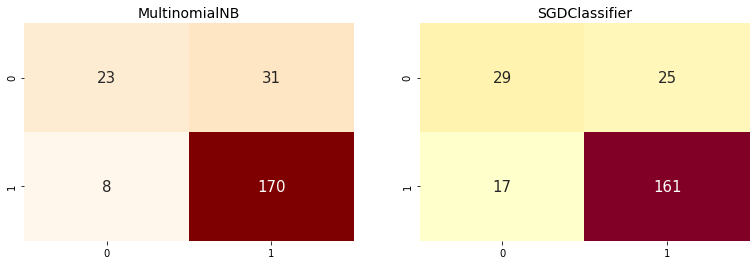

In [88]:
confusion_matrix_visualize(confusion_matrix(y_test,y_preds_nb_tfidf),confusion_matrix(y_test,y_preds_sgd_tfidf))

MultinomialNB made poor predictions with Tf-idf Vectorizer, but SGDClassifier predictions  slightly improved.

### 7. Oversampling with SMOTE 

In [89]:
nb_smote_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('smote', SMOTE(random_state=0,sampling_strategy='minority')),
    ('clf', MultinomialNB())])    

In [90]:
nb_smote = GridSearchCV(nb_smote_pipeline, parameters_nb, cv=5, scoring='f1_weighted')
nb_smote = nb_smote.fit(X_train, y_train)

In [91]:
nb_smote.best_params_

{'clf__alpha': 1,
 'vect__min_df': 5,
 'vect__ngram_range': (1, 2),
 'vect__stop_words': None}

In [92]:
y_preds_nb_smote = nb_smote.predict(X_test)

In [93]:
print_report('MultinomialNB with CountVectorizer and SMOTE',y_test,y_preds_nb_cv)


Classification Report for MultinomialNB with CountVectorizer and SMOTE

              precision    recall  f1-score   support

           0       0.69      0.76      0.73        54
           1       0.92      0.90      0.91       178

    accuracy                           0.87       232
   macro avg       0.81      0.83      0.82       232
weighted avg       0.87      0.87      0.87       232



In [94]:
f1_score(y_test,y_preds_nb_smote,average='weighted')

0.844582973421292

In [95]:
sgd_smote_pipeline = Pipeline([('vect', TfidfVectorizer()),
                               ('smote', SMOTE(random_state=0,sampling_strategy='minority')),
                               ('clf', SGDClassifier())])  

In [96]:
sgd_smote = GridSearchCV(sgd_smote_pipeline, parameters_sgd, cv=5, scoring='f1_weighted')
sgd_smote = sgd_smote.fit(X_train, y_train)

In [97]:
sgd_smote.best_params_

{'clf__loss': 'log',
 'clf__penalty': 'elasticnet',
 'vect__min_df': 5,
 'vect__ngram_range': (1, 2),
 'vect__stop_words': None}

In [98]:
y_preds_sgd_smote = sgd_smote.predict(X_test)

In [99]:
print_report('SGDClassifier with TfidfVectorizer and SMOTE',y_test,y_preds_sgd_smote)


Classification Report for SGDClassifier with TfidfVectorizer and SMOTE

              precision    recall  f1-score   support

           0       0.69      0.76      0.73        54
           1       0.92      0.90      0.91       178

    accuracy                           0.87       232
   macro avg       0.81      0.83      0.82       232
weighted avg       0.87      0.87      0.87       232



In [100]:
f1_score(y_test,y_preds_sgd_smote,average='weighted')

0.8263279941598317

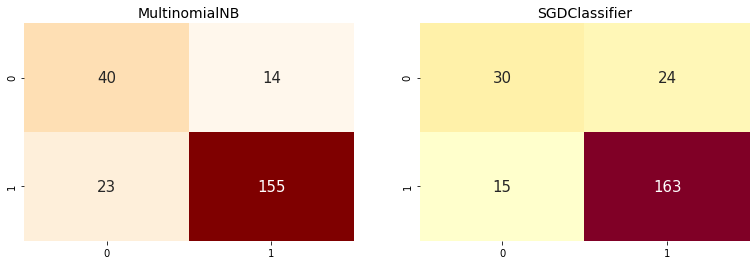

In [101]:
confusion_matrix_visualize(confusion_matrix(y_test,y_preds_nb_smote),confusion_matrix(y_test,y_preds_sgd_smote))

Predictions for SGDClassifier slightly improved with oversampling. 

### 8. Saving the model 

In [102]:
# saving MultinomialNB with CountVectorizer since it made the best predictions
dump(nb_cv,'model.joblib') 

['model.joblib']